# Градиентный метод решения обратной задачи для одномерного стохастического дифференциального уравнения

Работа посвящена решению обратной задачи для одномерного стохастического дифференциального уравнения (СДУ), а именно – восстановлению
коэффициента дрейфа по дополнительной информации о нескольких траекториях СДУ в фиксированный момент времени. Плотность случайных
величин удовлетворяет решению нестационарного уравнения Колмогорова-
Фоккера-Планка. Задача формулируется в виде нелинейного операторного
уравнения. 

## Постановка прямой задачи

Рассматривается случай, когда коэффициент дрейфа является функцией от $X(t)$, а волотильность постоянна. В этом случае общий вид СДУ:
$$
  dX(t)=\mu(X(t))  dt +  \sigma  dW(t), 
$$
Здесь $t \in [0,T]$ - время, $X(t)$ - случайная величина, $W(t)$ - стандартный Винеровский процесс, $\mu(x)$ - коэффициент дрейфа (математическое ожидание), $\sigma$ - волатильность (дисперсия). 

Под прямой задачей в данной работе понимается задача нахождения случайной величины $X(t)$, которая описывается стохастическим дифференциальным уравнением.

## Численное решение прямой задачи

Для построения разностной схемы введем равномерную по времени сетку с шагом $ \Delta t = {T}/{N_t}$, где $N_t$ - количество узлов.

Прямая задача решается методом Эйлера - Маруямы:
$$   X_{i+1} = X_i + \mu_i  \Delta t + \sigma  \Delta W_i,\qquad \Delta W_i=z_i \sqrt{\Delta t},$$
где $z_i \sim N(0,1)$ - гауссовы случайные величины с нулевым средним и единичной дисперсией.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.interpolate as spi
from matplotlib import pylab

In [6]:
sigma = 0.5
t_init = 0
t_end = 1
x_end = 1
x_init = -1
Nx = 600  # кол-во узлов по пространству
Nt = 300  # кол-во узлов по времени
n = 500  # кол-во данных
Number_iter = 800  # кол-во итераций
T_fix = 300  # номер узла(!) фиксации
delta = 0.15  # уровень шума

In [7]:
def dW(delta_t):
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))

Рассмотрим для примера $\mu=-5 x ^3 + 2 x$, $X_0$ = 0 

In [8]:
def func_mu(x):
    return -5 * x ** 3 + 2 * x

In [9]:
# Метод Эйлера-Маруяма для решения СДУ для точного мю
def EM(sigma: int, dt: int, time: np.arange, seed: int):
    '''
    sigma - волатильность 
    dt - шаг по времени
    time - равномерная сетка по времени
    seed -  начальные условия для генератора случайных чисел
    '''
    N = time.size - 1
    np.random.seed(seed)
    X_0 = 0
    mu = np.zeros(N + 1)
    X_new = np.zeros(N + 1)
    X_new[0] = X_0
    mu[0] = -5 * X_0 ** 3 + 2 * X_0   # точное мю
    for i in range(1, time.size):
        y = X_new[i - 1]
        X_new[i] = y + mu[i - 1] * dt + sigma * dW(dt)
        mu[i] = func_mu(X_new[i])
    return X_new

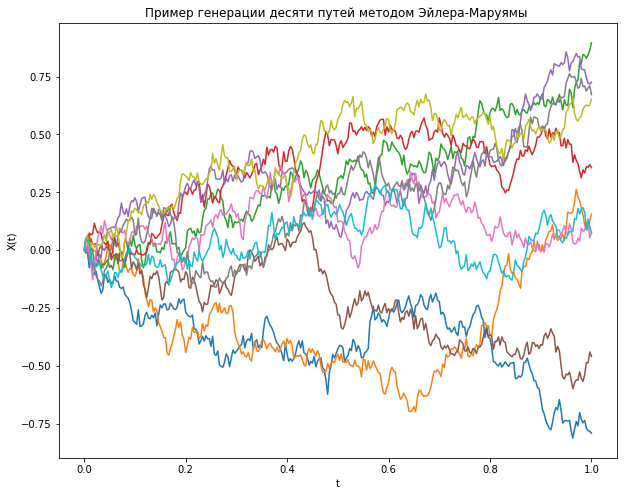

In [10]:
#массив для Х(t) из СДУ
X = []

#введем равномерную сетку по времни
dt = float(t_end - t_init) / Nt
time = np.arange(t_init, t_end + dt, dt)

fig = plt.figure() 
fig.set_size_inches(10, 8) # задаем размер

# генерируем n путей для ТОЧНОГО мю
for j in range(n):
    seed = j + 2
    X.append(EM(sigma, dt, time, seed))
    if j < 10: 
        plt.plot(time, X[j])
plt.xlabel('t')
plt.ylabel('X(t)')
plt.title('Пример генерации десяти путей методом Эйлера-Маруямы ')
plt.show()

# сохраняем Х в фиксированный момент времени
X_for_T_fix = []
for j in range(0, int(n)):
    X_for_T_fix.append(X[j][T_fix])

# упорядочим массив данных Х(Т)
X_for_T_fix.sort()

#равномерная сетка по пространству
dx = float(x_end - x_init) / Nx
X_mesh = np.arange(x_init, x_end + dx, dx)

#точное значение мю
mu_exact = np.zeros(len(X_mesh))
for i in range(0, len(X_mesh)):
    mu_exact[i] = func_mu(X_mesh[i])

## Постановка обратной задачи

В обратной задаче требуется восстановить функцию $\mu(x)$ по измерениям в фиксированный момент времени  $X^i(T)$, $i=1,\dots,n$.
 Здесь $X^i(T)$ - решение прямой задачи в момент времени $T$. Также предполагается, что $X(0)$ и $\sigma$ = $const$ известны. 

Сформулируем обратную задачу в виде нелинейного
операторного уравнения:
$$
  F(\mu) = u(x,T;\mu),\qquad \qquad(1)
$$
где $u(x,T;\mu)$ - решение уравнения Колмогорова-Фоккера-Планка в фиксированный момент времени $T$, $\mu=\mu(x)$ - искомая функция.
 
В качестве правой части уравнения (1) мы имеем $u^{obs}$ - эмпирическую плотность распределения для данных $X^i(T)$.

Эта обратная задача некорректна, т.к. данные задачи не полны. Поэтому следует применять алгоритмы регуляризации

Для определения плотности распределения $u(t,x)$ случайной величины $X(t)$ в СДУ мы используем решение начально-краевой задачи для уравнения Колмогорова-Фоккера-Планка (КФП):

\begin{eqnarray}\label{KFP}
\left\{\begin{array}{lll}
&\dfrac{ \partial u}{\partial t} = - \dfrac{\partial(\mu u)}{\partial x} + \dfrac{\sigma^{2}}{2}  \dfrac{\partial^2 u}{\partial x^2}= L_{\mu} u,  & t \in [0,T], x\in [l,L],
\\
& u(0,x)=u_0(x), & x\in [l,L],
\\
& u(l,t)=u(L,t)=0, & t \in [0,T],
\end{array}\right. \qquad \qquad (2)
\end{eqnarray}

$u_0=\delta_0$ - дельта-функция Дирака.


In [11]:
def Empirical_density(X: list, X_mesh_for_interp: list): 
    ''''
    Эмпиричекая плотность распределения
    '''
    N = len(X)
    num_density = 1 + int(math.log2(N))
    Max = max(X)
    Min = min(X)
    h_step = (Max - Min) / (num_density - 1) # шаг
    dens_step = [Min]
    Uo = np.zeros(num_density)
    X_mesh = np.zeros(num_density)
    for i in range(0, num_density):
        ai = Min + i * h_step
        ai1 = ai + h_step
        count = 0
        for j in range(0, N):
            if (ai <= X[j] < ai1):
                count += 1
        Uo[i] = count / (h_step * (N + 1))
        dens_step.append(ai1)
        X_mesh[i] = (h_step) / 2 + Min + i * h_step

    U = np.zeros(len(Uo)+2)
    X_mesh_for_U = np.zeros(len(X_mesh)+2)
    for i in range(0, num_density):
        U[i+1] = Uo[i]
        X_mesh_for_U[i+1] = X_mesh[i]
    X_mesh_for_U[0] = X_mesh_for_interp[0]
    X_mesh_for_U[len(X_mesh)+1] = X_mesh_for_interp[len(X_mesh_for_interp)-1]

    Uo_new = spi.interp1d(X_mesh_for_U, U, kind='cubic',
                          fill_value="extrapolate")(X_mesh_for_interp)
    
    plt.plot(X_mesh, Uo, 'o', X_mesh_for_interp, Uo_new, '-')
    plt.xlabel('X')
    plt.ylabel('Uo')
    plt.title('Эмпиричекая плотность распределения')
    plt.show()
    return Uo_new

In [12]:
def Fokker_Plank_schem1_for_mu(mu: list, sigma: int, X: list, T: list):
    '''
    Нахождение решения ур-ния Фоккера-Планка. 
    Неявная схема. 
    Прогонка.
    '''
    
    tau = T[1] - T[0]
    U = np.zeros((len(X), len(T)))
    Nx = len(X)
    A = np.zeros(Nx)
    B = np.zeros(Nx)
    C = np.zeros(Nx)
    F = np.zeros(Nx)

    z = 3

    # граничные условия
    for i in range(0, len(T)):
        U[0][i] = 0
        U[len(X) - 1][i] = 0

    # начальные условия
    for i in range(0, Nx):
        U[i][0] = (z/(np.sqrt(math.pi))) * np.exp(-(z*X[i])**2)

    for n in range(1, len(T)):

        for i in range(0, Nx - 1):
            A[i] = (-mu[i] / (X[i + 1] - X[i - 1])) - ((sigma ** 2) /
                                                       (2 * (X[i + 1] - X[i]) * (X[i] - X[i - 1])))
            B[i] = (1 / tau) + ((mu[i + 1] - mu[i - 1]) / (X[i + 1] - X[i - 1])) + (
                (sigma ** 2) / ((X[i + 1] - X[i]) * (X[i] - X[i - 1])))
            C[i] = (mu[i] / (X[i + 1] - X[i - 1])) - ((sigma ** 2) /
                                                      (2 * (X[i + 1] - X[i]) * (X[i] - X[i - 1])))

        for i in range(1, Nx - 2):
            F[i] = (1 / tau) * U[i][n - 1]

        F[0] = 0  # из граничных условий
        F[len(X) - 2] = 0  # из граничных условий

        alpha = [-C[0] / B[0]]
        beta = [F[0] / B[0]]

        for i in range(1, Nx - 1):
            alpha.append((-C[i]) / (A[i] * alpha[i - 1] + B[i]))
            beta.append((F[i] - A[i] * beta[i - 1]) /
                        (A[i] * alpha[i - 1] + B[i]))

        U[len(X) - 2][n] = beta[Nx - 2]

        for i in range(Nx - 2, 1, -1):
            U[i - 1][n] = alpha[i - 1] * U[i][n] + beta[i - 1]
    Result = U.transpose()
    return Result

Чтобы найти оператор $F'[\mu]$, продифференцируем  (2) по $\mu$:

\begin{eqnarray} \label{equation_for_dF}
\left\{\begin{array}{lll}
&\dfrac{ \partial v}{\partial t} = L_{\mu}v - \mbox{div}(hu), \quad  & t \in [0,T], x\in [l,L],
\\
& v(0,x)=0, & x\in [l,L],
\\
& v(l,t)=v(L,t)=0, & t \in [0,T],
\end{array}\right.
\end{eqnarray}

где $v(t,x) = \frac{ \partial u (t,x)}{\partial \mu} h$. Тогда 
\begin{equation}
    F'[\mu] h = v(x,T).
\end{equation}


In [13]:
def derivative_Fokker_Plank_schem1_for_mu(mu: list, sigma: int, X: list, T: list, U: list):
    '''
    Нахождение F'[mu]
    '''
    tau = T[1] - T[0]
    V = np.zeros((len(X), len(T)))
    Nx = len(X)
    A = np.zeros(Nx)
    B = np.zeros(Nx)
    C = np.zeros(Nx)
    F = np.zeros(Nx)

    # граничные условия
    for i in range(0, len(T)):
        V[0][i] = 0
        V[len(X) - 1][i] = 0

    # начальные условия
    for i in range(0, Nx):
        V[i][0] = 0

    for n in range(1, len(T)):

        for i in range(0, Nx - 1):
            A[i] = (-mu[i] / (X[i + 1] - X[i - 1])) - ((sigma ** 2) /
                                                       (2 * (X[i + 1] - X[i]) * (X[i] - X[i - 1])))
            B[i] = (1 / tau) + ((mu[i + 1] - mu[i - 1]) / (X[i + 1] - X[i - 1])) + (
                (sigma ** 2) / ((X[i + 1] - X[i]) * (X[i] - X[i - 1])))
            C[i] = (mu[i] / (X[i + 1] - X[i - 1])) - ((sigma ** 2) /
                                                      (2 * (X[i + 1] - X[i]) * (X[i] - X[i - 1])))

        for i in range(1, Nx - 2):
            F[i] = (1 / tau) * V[i][n - 1] - \
                (U[n][i + 1] - U[n][i - 1])/(X[i + 1] - X[i - 1])

        F[0] = 0  # из граничных условий
        F[len(X) - 2] = 0  # из граничных условий

        alpha = [-C[0] / B[0]]
        beta = [F[0] / B[0]]

        for i in range(1, Nx - 1):
            alpha.append((-C[i]) / (A[i] * alpha[i - 1] + B[i]))
            beta.append((F[i] - A[i] * beta[i - 1]) /
                        (A[i] * alpha[i - 1] + B[i]))

        V[len(X) - 2][n] = beta[Nx - 2]

        for i in range(Nx - 2, 1, -1):
            V[i - 1][n] = alpha[i - 1] * V[i][n] + beta[i - 1]
    Result = V.transpose()
    return Result

**Утверждение**

Сопряженный к $F'[\mu]$ оператор имеет вид:

\begin{equation} \label{adjoint}
F'[\mu]^* g = u(x,T;\mu) \frac{\partial}{\partial x} \left(\int^T_0 w(x,t)dt \right),
\end{equation}
 где $w(x,t)$ - решение следующей задачи:

\begin{equation} \label{equation_for_w}
\left\{\begin{array}{lll}
&\dfrac{ \partial w}{\partial t} = -\mu \dfrac{ \partial w}{\partial x} - \dfrac{\sigma^2}{2} \dfrac{ \partial^2 w}{\partial x^2} , \quad & t \in [0,T], x\in [l,L],
\\
& w(T,x)= g(x), & x\in [l,L],
\\
& w(l,t)=w(L,t)=0, & t \in [0,T].
\end{array}\right.
\end{equation}

In [14]:
def adjoint(mu: list, sigma: int, X: list, T: list, g):
    '''
    Нахождение сопряженного оператора
    '''
    tau = T[1] - T[0]
    W = np.zeros((len(X), len(T)))
    Nx = len(X)
    Nt = len(T)

    A = np.zeros(Nx)
    B = np.zeros(Nx)
    C = np.zeros(Nx)
    F = np.zeros(Nx)

    # граничные условия
    for i in range(0, len(T)):
        W[0][i] = 0
        W[len(X) - 1][i] = 0

    # начальные условия
    for i in range(0, Nx):
        W[i][Nt-1] = g[i]

    for n in range(len(T)-2, -1, -1):

        for i in range(0, Nx - 1):
            A[i] = (-mu[i] / (X[i + 1] - X[i - 1])) + ((sigma ** 2) /
                                                       (2 * (X[i + 1] - X[i]) * (X[i] - X[i - 1])))
            B[i] = (-1 / tau) - ((sigma ** 2) /
                                 ((X[i + 1] - X[i]) * (X[i] - X[i - 1])))
            C[i] = (mu[i] / (X[i + 1] - X[i - 1])) + ((sigma ** 2) /
                                                      (2 * (X[i + 1] - X[i]) * (X[i] - X[i - 1])))

        for i in range(1, Nx - 2):
            F[i] = (-1 / tau) * W[i][n+1]

        F[0] = 0  # из граничных условий
        F[len(X) - 2] = 0  # из граничных условий

        alpha = [-C[0] / B[0]]
        beta = [F[0] / B[0]]

        for i in range(1, Nx - 1):
            alpha.append((-C[i]) / (A[i] * alpha[i - 1] + B[i]))
            beta.append((F[i] - A[i] * beta[i - 1]) /
                        (A[i] * alpha[i - 1] + B[i]))

        W[len(X) - 2][n] = beta[Nx - 2]

        for i in range(Nx - 2, 1, -1):
            W[i - 1][n] = alpha[i - 1] * W[i][n] + beta[i - 1]

    Solve_adjoint = W.transpose()

    # интегрируем от 0 до Т найденное W(t,x)
    Int = np.zeros(Nx)

    for i in range(0, Nx):
        Int[i] = ((T[Nt-1] - T[0])/Nt) * \
            ((Solve_adjoint[0][i] + Solve_adjoint[Nt-1][i]) / 2)
        for j in range(1, Nt-1):
            Int[i] = Int[i] + ((T[Nt-1] - T[0])/Nt)*Solve_adjoint[j][i]

    return Int


Для линейных задач итерация Ландвебера известна как метод регуляризации. Итерацию Ландвебера можно обобщить на нелинейное операторное уравнение:
\begin{equation}\label{Lanweber}
\mu_{k+1} = \mu_k + \lambda F'[\mu_k]^*(u^{\delta} - F(\mu_k)), \quad k = 1,2,\dots,
\end{equation}
где k - номер итерации.

In [15]:
#массив для Х(t) из СДУ
X = []

#введем равномерную сетку по времни
dt = float(t_end - t_init) / Nt
time = np.arange(t_init, t_end + dt, dt)

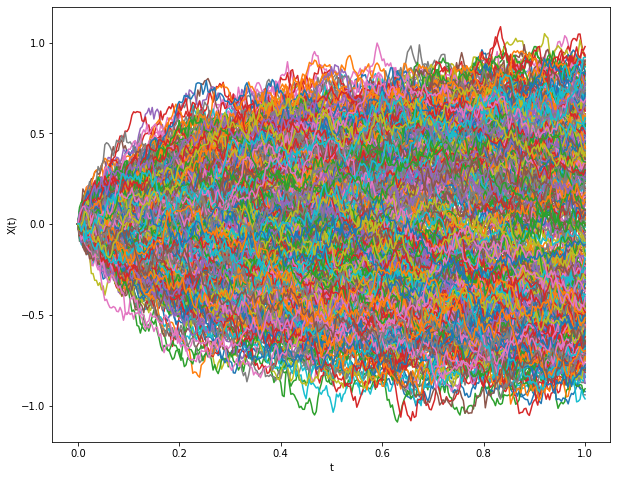

In [16]:
fig = plt.figure() 
fig.set_size_inches(10, 8) # задаем размер

# генерируем n путей для ТОЧНОГО мю
for j in range(0, n):
    seed = j + 2
    X.append(EM(sigma, dt, time, seed))
    plt.plot(time, X[j])
plt.xlabel('t')
plt.ylabel('X(t)')
plt.show()

In [17]:
# сохраняем Х в фиксированный момент времени
X_for_T_fix = []
for j in range(0, int(n)):
    X_for_T_fix.append(X[j][T_fix])


# упорядочим массив данных Х(Т)
X_for_T_fix.sort()

In [14]:
#равномерная сетка по пространству
dx = float(x_end - x_init) / Nx
X_mesh = np.arange(x_init, x_end + dx, dx)

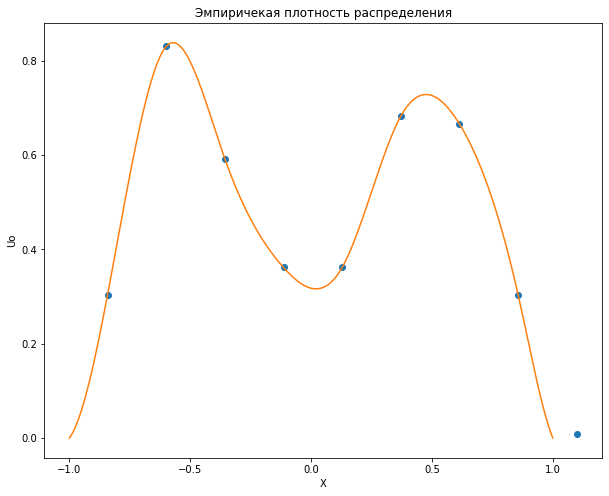

In [15]:
fig = plt.figure() 
fig.set_size_inches(10, 8) # задаем размер

# эмпирическая функция распределения для данных
U_exact=Empirical_density(X_for_T_fix, X_mesh)

In [16]:
#точное значение мю
mu_exact = np.zeros(len(X_mesh))
for i in range(0, len(X_mesh)):
    mu_exact[i] = -5 * X_mesh[i] ** 3 +2 * X_mesh[i]

In [17]:
#Решение уравнение Фоккера-Планка для точного мю
#U_for_exact_mu = Fokker_Plank_schem1_for_mu(mu_exact, sigma, X_mesh, time)
#U_for_exact_mu_fix = np.zeros(len(X_mesh))
#for i in range(0, len(X_mesh)):
#    U_for_exact_mu_fix[i] = U_for_exact_mu[T_fix][i]

In [18]:
#начальное приближение мю
mu = np.zeros(len(X_mesh))
mu_0=np.zeros(len(X_mesh))
for i in range(0, len(X_mesh)):
    mu[i] = 0
    mu_0[i]= 0

In [19]:
#начало цикла по итерациям
for k in range(0, Number_iter):

    # U - решение уравнения КФП для мю_к
    U = Fokker_Plank_schem1_for_mu(mu, sigma, X_mesh, time)

    # решение уравнения Ф-П в фиксированный момент времени
    U_fix_time = np.zeros(len(X_mesh))

    G=np.zeros(len(X_mesh))

    for i in range(0, len(X_mesh)):
        U_fix_time[i] = U[T_fix][i]
        G[i]=U_fix_time[i]-U_exact[i]

    #plt.plot(X_mesh, U_fix_time)
    #plt.xlabel('X')
    #plt.ylabel('U')
    #plt.show()

    #W = A^* G
    W = adjoint(mu,sigma,X_mesh,time,G)

    mu_next_iteration = np.zeros(len(X_mesh))

    #метод Ландвебера
    for i in range(0, len(X_mesh)):
        mu_next_iteration[i] = mu[i] - 0.5 * U_fix_time[i] * (W[i]-W[i-1])/(X_mesh[i]-X_mesh[i-1])

    for i in range (0,len(X_mesh)):
        mu[i]=mu_next_iteration[i]

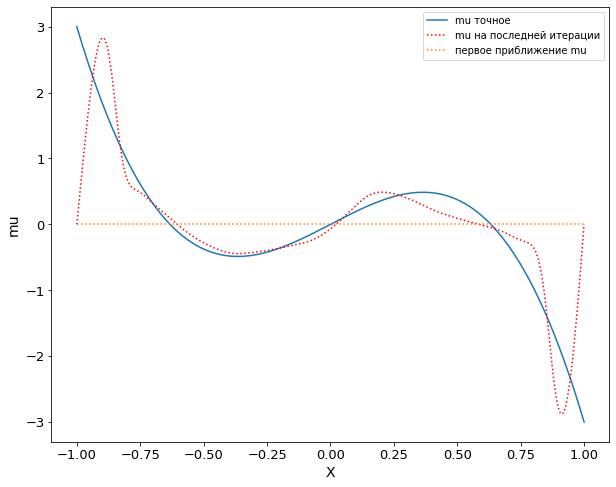

In [20]:
fig = plt.figure() 
fig.set_size_inches(10, 8) # задаем размер

mu_approx = np.zeros(len(X_mesh))
for i in range(0, len(X_mesh)):
    mu_approx[i] = mu[i]


plt.plot(X_mesh, mu_exact, label = 'mu точное ')
plt.plot(X_mesh, mu_approx,':', label = 'mu на последней итерации', color='r')
plt.plot(X_mesh, mu_0,':', label = 'первое приближение mu')
plt.xlabel('X',fontsize=14)
plt.ylabel('mu',fontsize=14)
plt.legend()
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()